# Historical Phone Usage

[TidyTuesday 2020-11-10](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-11-10)

**Contents:**

* [Setup and data load](#Setup-and-data-load)
* [Landline vs mobile trends](#Landline-vs-mobile-trends)
* [Continent correlations: landline](#Continent-correlations:-landline)
* [Continent correlations: mobile](#Continent-correlations:-mobile)
* [Continent correlations: phone total](#Continent-correlations:-phone-total)
* [Leading/lagging wrt Americas](#Leading/lagging-wrt-Americas)
* [Choropleth](#Choropleth)

## Setup and data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pycrs
from shapely import geometry
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [2]:
d = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/'
                'master/data/2020/2020-11-10/mobile.csv')
d = d[~d.mobile_subs.isna()]
mobile = d
print(mobile.info())
mobile

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5601 entries, 0 to 6275
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   entity       5601 non-null   object 
 1   code         5573 non-null   object 
 2   year         5601 non-null   int64  
 3   total_pop    4742 non-null   float64
 4   gdp_per_cap  4983 non-null   float64
 5   mobile_subs  5601 non-null   float64
 6   continent    5601 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 350.1+ KB
None


,entity,code,year,total_pop,gdp_per_cap,mobile_subs,continent
0,Afghanistan,AFG,1990,13032161.0,NaN,0.000000,Asia
1,Afghanistan,AFG,1991,14069854.0,NaN,0.000000,Asia
2,Afghanistan,AFG,1992,15472076.0,NaN,0.000000,Asia
3,Afghanistan,AFG,1993,17053213.0,NaN,0.000000,Asia
4,Afghanistan,AFG,1994,18553819.0,NaN,0.000000,Asia
...,...,...,...,...,...,...,...
6271,Zimbabwe,ZWE,2013,13327925.0,1929.765001,90.558714,Africa
6272,Zimbabwe,ZWE,2014,NaN,1925.138698,76.556585,Africa
6273,Zimbabwe,ZWE,2015,NaN,1912.280261,80.858499,Africa
6274,Zimbabwe,ZWE,2016,NaN,1879.628119,79.743884,Africa


In [3]:
d = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/'
                'master/data/2020/2020-11-10/landline.csv')
d = d[~d.landline_subs.isna()]
landline = d
print(landline.info())
landline

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5695 entries, 0 to 6970
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   entity         5695 non-null   object 
 1   code           5667 non-null   object 
 2   year           5695 non-null   int64  
 3   total_pop      5667 non-null   float64
 4   gdp_per_cap    4993 non-null   float64
 5   landline_subs  5695 non-null   float64
 6   continent      5695 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 355.9+ KB
None


,entity,code,year,total_pop,gdp_per_cap,landline_subs,continent
0,Afghanistan,AFG,1990,12412000.0,NaN,0.295532,Asia
1,Afghanistan,AFG,1991,13299000.0,NaN,0.284754,Asia
2,Afghanistan,AFG,1992,14486000.0,NaN,0.207421,Asia
3,Afghanistan,AFG,1993,15817000.0,NaN,0.192115,Asia
4,Afghanistan,AFG,1994,17076000.0,NaN,0.179314,Asia
...,...,...,...,...,...,...,...
6966,Zimbabwe,ZWE,2013,13350000.0,1929.765001,2.020405,Africa
6967,Zimbabwe,ZWE,2014,13587000.0,1925.138698,2.137827,Africa
6968,Zimbabwe,ZWE,2015,13815000.0,1912.280261,2.115056,Africa
6969,Zimbabwe,ZWE,2016,14030000.0,1879.628119,1.892961,Africa


In [4]:
cols = 'entity code continent year total_pop gdp_per_cap'.split()
data = mobile[cols + ['mobile_subs']].merge(landline[cols + ['landline_subs']], on=cols[:-2])
data['phone_subs'] = data.mobile_subs + data.landline_subs
data['total_pop'] = np.maximum(data.total_pop_x, data.total_pop_y)
data['gdp_per_cap'] = np.maximum(data.gdp_per_cap_x, data.gdp_per_cap_y)
data = data.drop(columns='total_pop_x total_pop_y gdp_per_cap_x gdp_per_cap_y'.split())
data

,entity,code,continent,year,mobile_subs,landline_subs,phone_subs,total_pop,gdp_per_cap
0,Afghanistan,AFG,Asia,1990,0.000000,0.295532,0.295532,13032161.0,NaN
1,Afghanistan,AFG,Asia,1991,0.000000,0.284754,0.284754,14069854.0,NaN
2,Afghanistan,AFG,Asia,1992,0.000000,0.207421,0.207421,15472076.0,NaN
3,Afghanistan,AFG,Asia,1993,0.000000,0.192115,0.192115,17053213.0,NaN
4,Afghanistan,AFG,Asia,1994,0.000000,0.179314,0.179314,18553819.0,NaN
...,...,...,...,...,...,...,...,...,...
5561,Zimbabwe,ZWE,Africa,2013,90.558714,2.020405,92.579119,13350000.0,1929.765001
5562,Zimbabwe,ZWE,Africa,2014,76.556585,2.137827,78.694412,NaN,1925.138698
5563,Zimbabwe,ZWE,Africa,2015,80.858499,2.115056,82.973555,NaN,1912.280261
5564,Zimbabwe,ZWE,Africa,2016,79.743884,1.892961,81.636845,NaN,1879.628119


## Landline vs mobile trends

In [5]:
continents = (
    data
    [data.total_pop.gt(0)]
    .groupby('year continent'.split())
    .apply(lambda x: pd.Series(dict(
        total_pop = x.total_pop.sum(),
        mobile_subs = (x.mobile_subs * x.total_pop).sum() / x.total_pop.sum(),
        landline_subs = (x.landline_subs * x.total_pop).sum() / x.total_pop.sum(),
        phone_subs = (x.phone_subs * x.total_pop).sum() / x.total_pop.sum(),
    )))
    .reset_index()
)

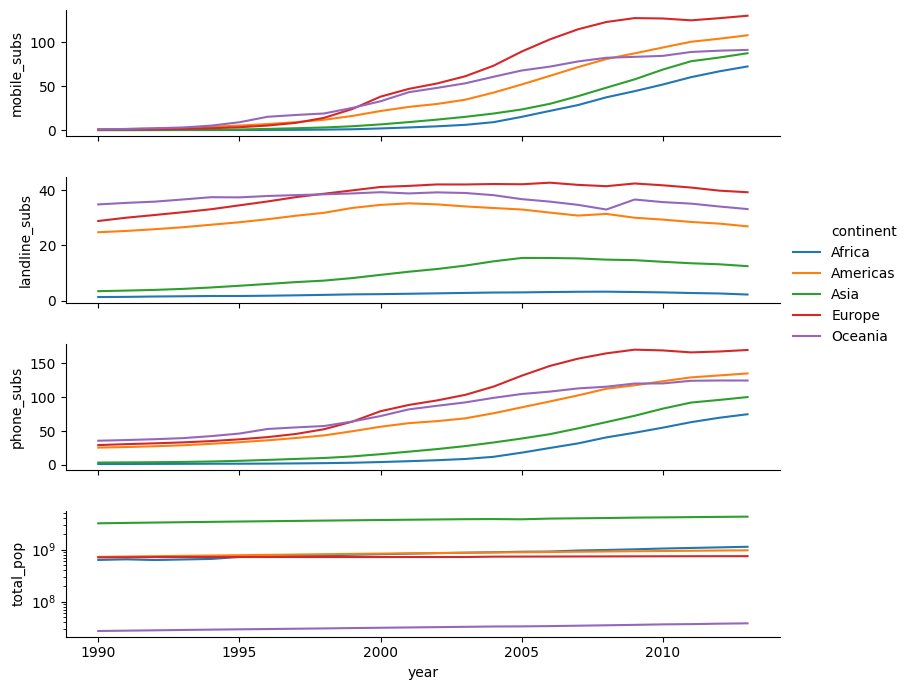

In [6]:
fig, axs = plt.subplots(4, figsize=(8,7), sharex=True)
sns.lineplot(
    'year', 'mobile_subs', hue='continent', ax=axs[0], data=continents, legend=False)
sns.lineplot(
    'year', 'landline_subs', hue='continent', ax=axs[1], data=continents, legend=False)
sns.lineplot(
    'year', 'phone_subs', hue='continent', ax=axs[2], data=continents)
sns.lineplot(
    'year', 'total_pop', hue='continent', ax=axs[3], data=continents, legend=False)
axs[-1].semilogy()
plt.tight_layout()
axs[2].legend(loc='lower left', bbox_to_anchor=[1,.9], frameon=False);

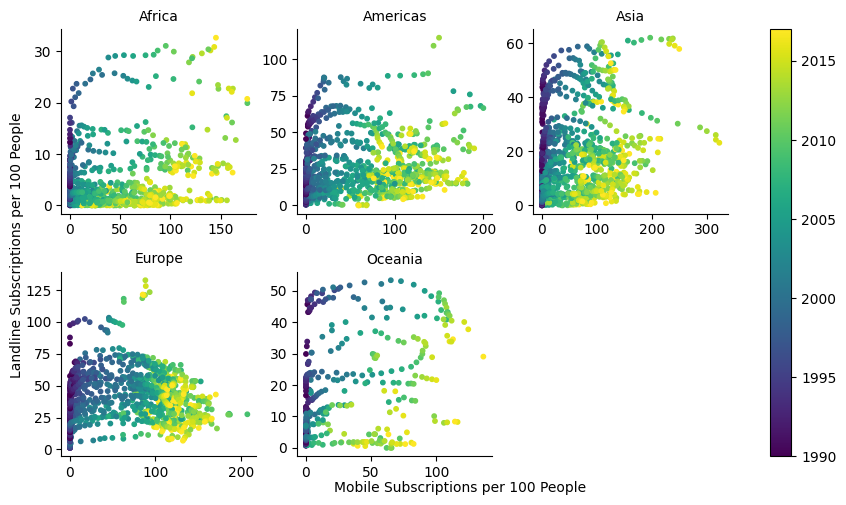

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(9,5))
axs = axs.ravel()
for (ax, (continent, d)) in zip(axs, data.groupby('continent')):
    sc = ax.scatter(d.mobile_subs, d.landline_subs, c=d.year, s=10)
    ax.set_title(continent, size='medium')
axs[-1].set_visible(False)
plt.tight_layout()
fig.text(.5, 0, 'Mobile Subscriptions per 100 People', ha='center', va='bottom')
fig.text(0, .5, 'Landline Subscriptions per 100 People', rotation=90, ha='left', va='center')
fig.colorbar(sc, ax=axs[:-1].tolist(), )

## Continent correlations: landline

In [8]:
pcontinents = continents.pivot('year', 'continent')

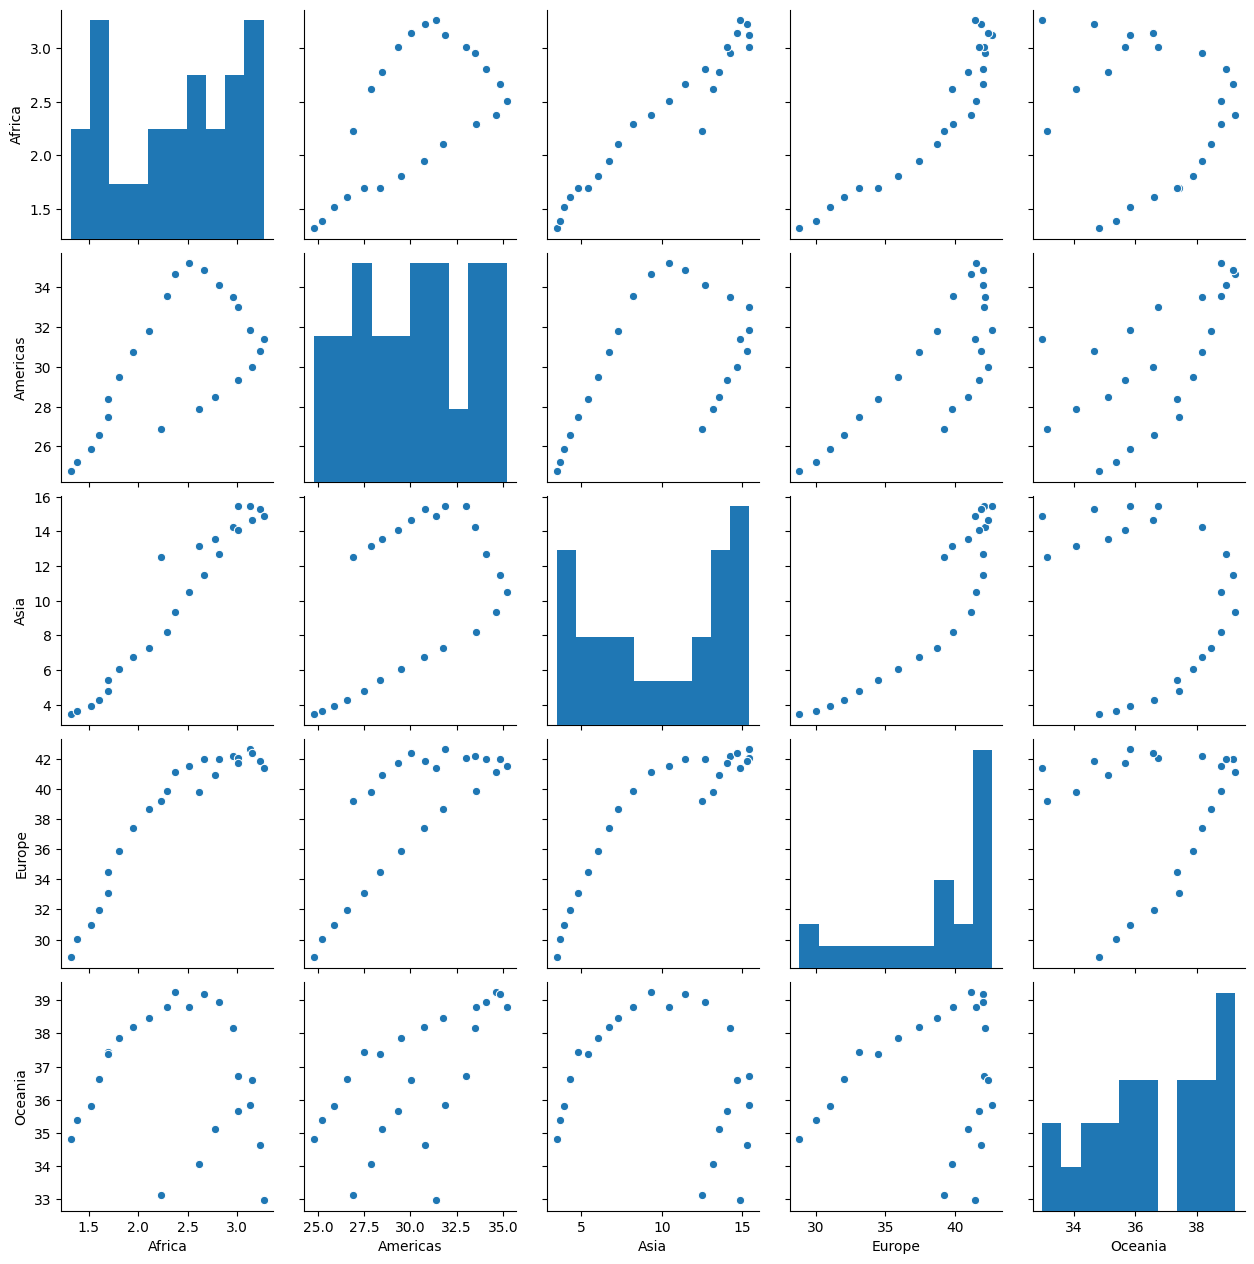

In [9]:
sns.pairplot(pcontinents.landline_subs)

## Continent correlations: mobile

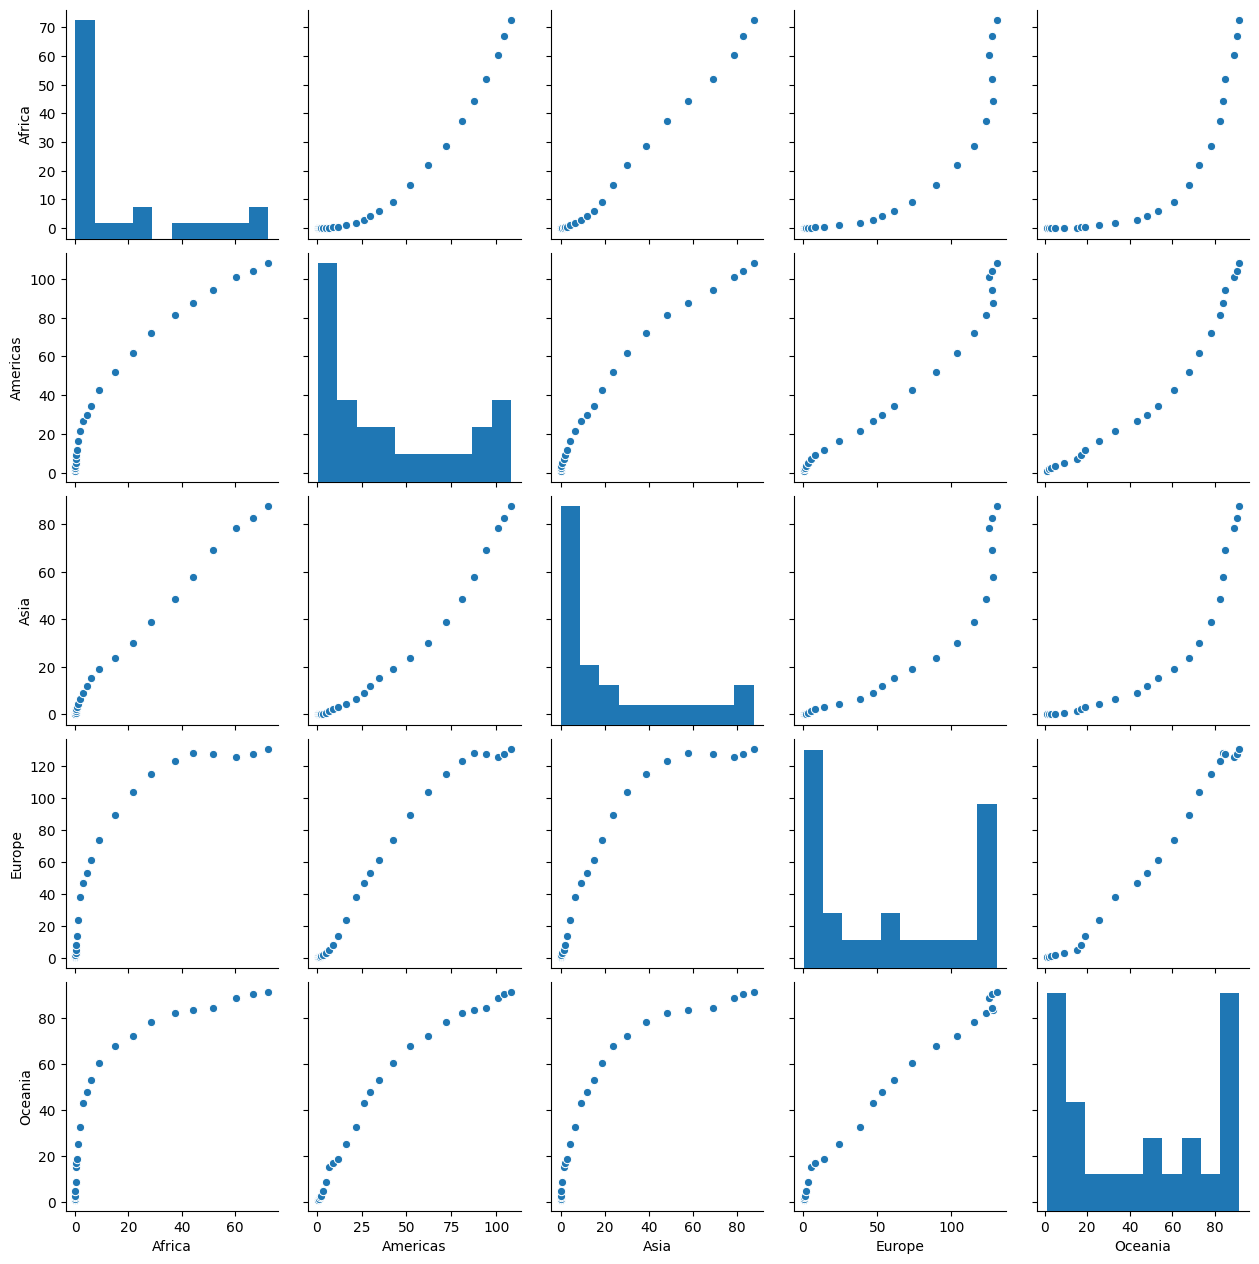

In [10]:
sns.pairplot(pcontinents.mobile_subs)

## Continent correlations: phone total

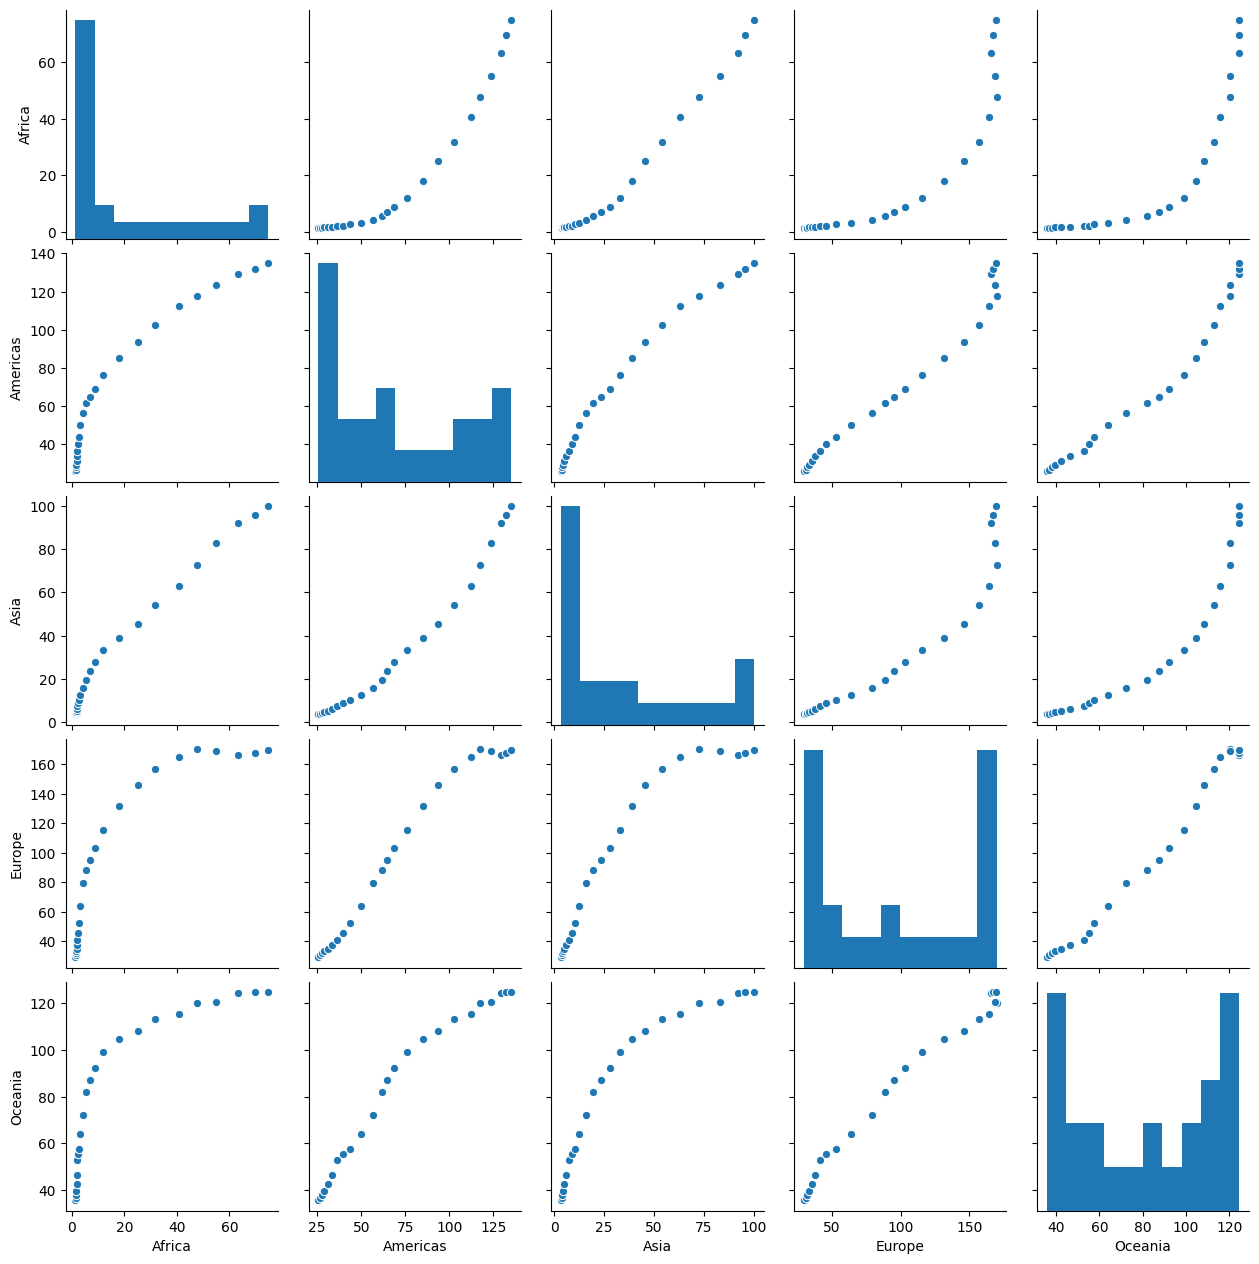

In [11]:
sns.pairplot(pcontinents.phone_subs)

## Leading/lagging wrt Americas

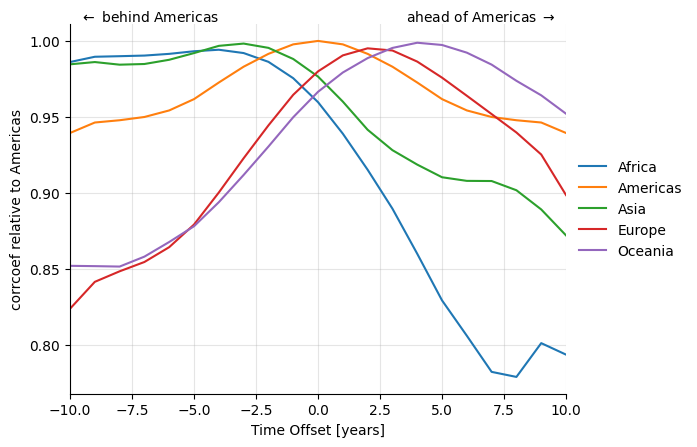

In [12]:
ms = pcontinents.mobile_subs
lags = np.r_[-10:11]
d = pd.DataFrame({col: [ms.Americas.corr(ms[col].shift(lag)) for lag in lags]
                  for col in ms.columns},
                 index=lags)
ax = d.plot()
ax.set(xlabel='Time Offset [years]', ylabel='corrcoef relative to Americas',
       xlim=(lags.min(), lags.max()))
ax.legend(loc='center left', bbox_to_anchor=[1,.5], frameon=False)
ax.text(.98, 1, r'ahead of Americas $\rightarrow$',
        ha='right', va='bottom', transform=ax.transAxes)
ax.text(.02, 1, r'$\leftarrow$ behind Americas',
        ha='left', va='bottom', transform=ax.transAxes)
ax.grid()

<AxesSubplot:xlabel='year', ylabel='mobile_subs'>

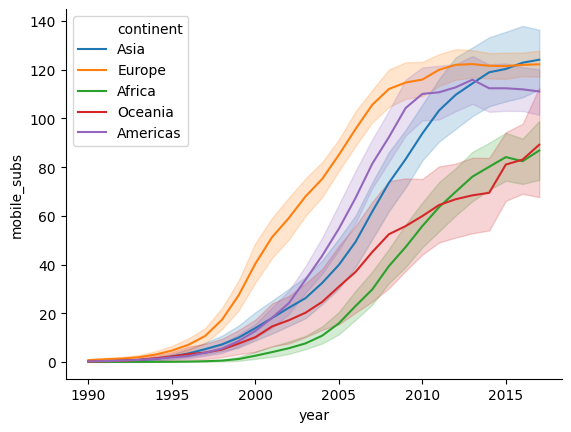

In [13]:
sns.lineplot('year', 'mobile_subs', hue='continent', data=data)

## Choropleth

In [14]:
# base geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = {'init': 'epsg:4326'}

# add boundary
lons, lats = np.linspace(-180, 180, 100), np.linspace(-90, 90, 100)
boundary = Polygon(
    [(lon, -90) for lon in lons]
    + [(180, lat) for lat in lats]
    + [(lon, 90) for lon in reversed(lons)]
    + [(-180, lat) for lat in reversed(lats)])
bworld = world.append(pd.Series(dict(
    continent='Border', iso_a3='boundary', geometry=boundary)), ignore_index=True)

# project
# 54030: Robertson
pworld = bworld.to_crs(pycrs.parse.from_esri_code(54030).to_proj4())
pworld = pworld[pworld.continent.ne('Antarctica')]

/Users/mrichman/ve/main/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


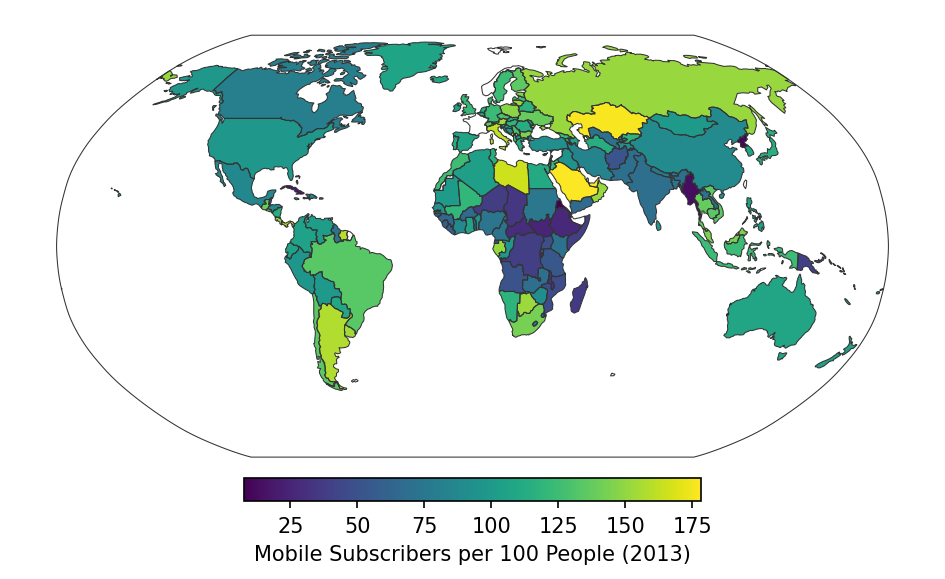

In [15]:
fig, ax = plt.subplots(dpi=150)

pworld.boundary.plot(lw=.5, color='.2', ax=ax)

d = pworld.merge(data[data.year.eq(2013)], left_on='iso_a3', right_on='code', how='inner')
d.plot(
    'mobile_subs',
    ax=ax,
    legend=True, legend_kwds=dict(
        orientation='horizontal', pad=0, fraction=.1, shrink=.5,
        label='Mobile Subscribers per 100 People (2013)'
    )
)
ax.axis('off')
plt.tight_layout()